# Datatonic Graduate Challenge: Data Wrangling using OpenLibrary's public API

**Instructions**

This notebook contains the following:

1. Lord of the Rings Dataset
2. OpenLibrary Specific Dataset
3. Exploratory Analysis of Specific Dataset

Before running all cells, please ensure you have the following packages installed:
    - requests
    - numpy
    - pandas
    - luqum
    - time
    - random
    - pickle
    - matplotlib
    - seaborn

**Additional Resources**
- Dependencies are also available in the accompanying *requirements.txt* file
- Additional documentation for the coding decisions and background research for this analysis can be found [here.](https://elegant-pastry-d54.notion.site/Open-Library-Data-Challenge-f05b37d22e8a48aeb598e8ec55d3de57)

In [1]:
# All imports
import requests
import numpy as np
import pandas as pd
from luqum.parser import parser
from luqum.pretty import prettify
import time
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## Lord of the Rings Dataset

### Task 1. Parse Available Datasets
- Write a Python script that retrieves a list of all books with the title “lord of the rings” from [this](https://openlibrary.org/dev/docs/api/search) API 
- Parse the response from the API and write the names of the books to a dataset.
- Add 4 other columns showing data from the response

1.1 Let's start by setting the parameters for our API call and fetching the works from Open Library API with the title 'lord of the rings'

In [2]:
# API Endpoint and Parameters
url = "https://openlibrary.org/search.json"
params = {
    'title': 'lord of the rings',
    'limit': 1000
}

# Call API and write response into the variable lotr_data
response = requests.get(url, params=params)  
if response.status_code == 200:
    lotr_data = response.json()
    print(f"OpenLibrary has {lotr_data['numFound']} works with title 'lord of the rings'")
else:
    response.raise_for_status()

OpenLibrary has 437 works with title 'lord of the rings'


Next let's parse the response and write all the results that are books to a list. 
- I'm defining book as either a paperback, hardcover, or e-book format.
- I'm going to include results that do not have a 'format' listed by default.

In [3]:
# Instantiate list for books
lotr_books = [] 

# Loop through each result to determine we consider it a book
for doc in lotr_data['docs']:
    try:
        formats = doc['format']
        if any(fmt.lower() in ['paperback', 'hardcover', 'e-book'] for fmt in formats):
            lotr_books.append(doc)
    except KeyError:
        # Add to list if there is no 'format' key
        lotr_books.append(doc)
    except Exception as e:
        print(f"Other Error: {e}")

print(f"{len(lotr_books)} of the {lotr_data['numFound']} are books")

399 of the 437 are books


Now that we have our list of books, let's save it into a DataFrame. 
In addition to the title, let's include 4 other columns:
- Author ('author_name')
- Year of First Publication ('first_publish_year')
- Publisher ('publisher')
- Language ('language')

In [4]:

# Save our dataset as a Dataframe
lotr_df = pd.DataFrame.from_records(lotr_books)[['title', 'author_name', 'first_publish_year', 'publisher', 'language']]

# Save the dataset to a CSV file
lotr_df.to_csv('lotr_books.csv', index=False)

lotr_df.head()

,title,author_name,first_publish_year,publisher,language
0,The Lord of the Rings,[J.R.R. Tolkien],1954.0,"[Houghton Mifflin Harcourt, Klett-Cotta Verlag...","[cat, rus, jpn, spa, fre, swe, ger, kor, pol, ..."
1,Novels (Hobbit / Lord of the Rings),[J.R.R. Tolkien],1979.0,"[Highbridge Audio, Mariner Books, HarperCollin...","[eng, rus]"
2,The Lord of the Ring,"[Phil Anderson, Philip A. Anderson]",2006.0,"[Regal Books, Muddy Pearl, Kingsway Publications]",[eng]
3,Lord of the Rings,[Cedco Publishing],2001.0,[Cedco Publishing Company],[eng]
4,The lord of the rings,[Jude Fisher],2001.0,"[HarperCollins, Houghton Mifflin]",[eng]


## Open Library Reader Engagement: Data Collection and Exploration

**Specifically: *What are the trends in Open Library's users' preferences and engagement?*** 

**Scoping and Assumptions:**

*Query Scope*
- I will be limiting my query to works that **are written in english**, have **at least one readinglog_count** and have **at least one rating_count**.

*Measures of popularity and preference*
- I will be using **readinglog_count** and **rating** as the outcome measures.
  - Its important to note that readinglog_count does not indicate the number of times that a book has been borrowed through OpenLibrary, but is a sum of the user-entered fields *want_to_read_count, currently_reading_count*, and *already_read_count*.
  - This means it is not the perfect measure of popularity of a book - ideally we'd use data from the borrowing log, or page clicks. I reached out to the OpenLibrary program manager 'Mek' (Michael...) however he confirmed this data is not available to the public. So we'll have to rely on this for now.

*Features under consideration*
- The following features are being considered to determine which factors are the best predictors (and therefore make the greatest contribution) to the popularity and rating of books for OpenLibrary's users.
  - 'first_publish_year, title, author_name, language, number_of_pages_median,publisher, subject, ratings_average, ratings_sortable, ratings_count, readinglog_count'

### Task 2. Retrieve a Specific Dataset:
- Using any of the other API’s available in the above link, construct a dataset using a query that you have put together and fetched data for via the API. Use the examples listed as guidance on how to construct these queries

**API Prep:**
1. Construct query using luqum (to be readable by apache solr, the query type specified in OpenLibrary's documentation)

In [5]:
# Create a query for works written in english with at least one readinglog_count and at least one rating
query = parser.parse('readinglog_count:[1 TO *] AND ratings_count:[1 TO *] AND language:eng')

# Convert the query to a Solr query string
solr_query = prettify(query)
print(solr_query)

readinglog_count: [1 TO *] AND ratings_count: [1 TO *] AND language: eng


2. Create api call as a function (to include error handling and retry, delay and jitter in case of error / failure)

In [6]:
def call_openlib_api(solr_query, offset='start', limit=1, sort='readinglog', max_retries=5):
    """
    Fetches books from Open Library API based on a pre-defined query.
    Includes retry, exponential backoff and 'jitter' for robustness 
    
    Args:
    solr_query (str): Query that has been parsed and pretti-fied by luqum.
    offset ():
    limit (int): The maximum number of results to fetch. Default set to 1 for test
    sort (string):
    max_retries (int):
    
    Returns:
    dict: A json dictionary with the following keys - 'numFound', 'start', 'numFoundExact', 'docs', 'num_found', 'q', 'offset'.
    """
    
    # API Call Setup
    api_url = 'http://openlibrary.org/search.json'
    params = {
        'q': solr_query,
        'sort': sort,
        'fields': 'first_publish_year,title,author_name,number_of_pages_median,publisher,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count',
        'offset': offset,
        'limit': limit  # Limit sample of results
    }

    # Setup Retry, delay and jitter in case of error / failure
    retry_delay = 1  # Initial delay in seconds
    
    for attempt in range(max_retries):
        # Execute API Call with error handling
        try:
            response = requests.get(api_url, params=params)
            response.raise_for_status()  # Raise an error on bad status codes
            return response.json()
        # If API Call fails, retry after delay and print error message
        except requests.RequestException:
            # Delay before retry
            time.sleep(retry_delay)
            retry_delay *= 2  # Double the delay for the next attempt
            retry_delay += random.uniform(0, 1)  # Add jitter
            
            # Print message for error type
            if requests.exceptions.HTTPError:
                print(f"HTTP error occurred: {requests.exceptions.HTTPError}")
            if requests.exceptions.ConnectionError:
                print(f"Connection error occurred: {requests.exceptions.ConnectionError}")
            if requests.exceptions.Timeout:
                print(f"Timeout occurred: {requests.exceptions.Timeout}")
            elif requests.exceptions.RequestException:
                print(f"General error occurred: {requests.exceptions.RequestException}")
    raise Exception("Maximum retry attempts reached")


3. Test API call function for a single line and record total number of records returned for query

In [7]:
# Test API call on single row and get total results:
total_records = call_openlib_api(solr_query)['numFound']
total_records

167509

4. Run API call function to get all results (This will take a couple minutes!)

In [8]:
# Instantiate list to store response
all_data = []

records_per_page = 10000 # specified max in Open Lib Documentation for API performance

# Call API with pagination
for start in range(0, total_records, records_per_page):
    page_data = call_openlib_api(solr_query, offset=start, limit=records_per_page)
    if page_data:
        all_data.extend(page_data['docs'])
        print(f"Retrieved {len(page_data['docs'])} records, Total: {len(all_data)} ({round(len(all_data)/total_records*100,0)}% Complete)")
    else:
        print("Failed to retrieve data. Exiting.")
        break
    time.sleep(1) # Throttle requests to avoid rate limiting

Retrieved 10000 records, Total: 10000 (6.0% Complete)
Retrieved 10000 records, Total: 20000 (12.0% Complete)
Retrieved 10000 records, Total: 30000 (18.0% Complete)
Retrieved 10000 records, Total: 40000 (24.0% Complete)
Retrieved 10000 records, Total: 50000 (30.0% Complete)
Retrieved 10000 records, Total: 60000 (36.0% Complete)
Retrieved 10000 records, Total: 70000 (42.0% Complete)
Retrieved 10000 records, Total: 80000 (48.0% Complete)
Retrieved 10000 records, Total: 90000 (54.0% Complete)
Retrieved 10000 records, Total: 100000 (60.0% Complete)
Retrieved 10000 records, Total: 110000 (66.0% Complete)
Retrieved 10000 records, Total: 120000 (72.0% Complete)
Retrieved 10000 records, Total: 130000 (78.0% Complete)
Retrieved 10000 records, Total: 140000 (84.0% Complete)
Retrieved 10000 records, Total: 150000 (90.0% Complete)
Retrieved 10000 records, Total: 160000 (96.0% Complete)
Retrieved 7509 records, Total: 167509 (100.0% Complete)


**Save Dataset**

Let's save our results so we can reuse them in the future (avoid calling the API again)

In [9]:
# Save to a pikl file for reuse
with open('openlib_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)

and let's load our data into a dataframe (either from the list we just ran or from the pikl file we saved)

In [13]:
if all_data:
    data_df = pd.DataFrame.from_records(all_data)
else:
    # Open saved pikl file
    with open('openlib_data.pkl', 'rb') as f:
        pickled_data = pickle.load(f)
        data_df = pd.DataFrame.from_records(pickled_data)

data_df.head()

,author_name,first_publish_year,number_of_pages_median,publisher,title,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count
0,[Colleen Hoover],2012.0,384.0,"[위즈덤 하우스, Simon & Schuster Ltd, Epsilon Yayine...",It Ends With Us,"[Fiction, Romance, Contemporary, Life change e...",4.237696,4.161838,955,38744
1,[James Clear],2016.0,320.0,"[Random House, Incorporated, editora alta book...",Atomic Habits,"[Habit, Habit breaking, Behavior modification,...",4.054461,3.967740,863,38352
2,"[Robert Greene, Joost Elffers]",1998.0,452.0,"[Espasa, HighBridge Company; Abridged, Grupo O...",The 48 Laws of Power,"[Business, Control (Psychology), Contrôle (Psy...",4.127389,4.038035,785,32517
3,[Mark Manson],2016.0,224.0,"[HarperLuxe, Harpercollins, Mark Manson , Inde...",The Subtle Art of Not Giving a F*ck,"[Self-realization, Conduct of life, Conducta d...",4.116279,4.015137,602,29438
4,"[Robert T. Kiyosaki, Sharon L. Lechter]",1990.0,233.0,"[Running Press, Bespoke Books, Gao Bao/ Tsai F...","Rich Dad, Poor Dad","[Rich people, Personal Finance, Investments, F...",4.083707,3.987700,669,21948


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167509 entries, 0 to 167508
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   author_name             166543 non-null  object 
 1   first_publish_year      167245 non-null  float64
 2   number_of_pages_median  149430 non-null  float64
 3   publisher               164383 non-null  object 
 4   title                   167509 non-null  object 
 5   subject                 149518 non-null  object 
 6   ratings_average         167509 non-null  float64
 7   ratings_sortable        167509 non-null  float64
 8   ratings_count           167509 non-null  int64  
 9   readinglog_count        167509 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 12.8+ MB


### Data Cleanup
- Check null
- Filter range of number of pages
- Filter range of year of first publication
- Check duplicates using a title + author composite column
    - Since it is possible to have the same title for different books AND for one author to have published multiple books

In [15]:
# Check for missing / null data
data_df.isnull().sum().sort_values(ascending=False) / len(data_df)

number_of_pages_median    0.107929
subject                   0.107403
publisher                 0.018662
author_name               0.005767
first_publish_year        0.001576
title                     0.000000
ratings_average           0.000000
ratings_sortable          0.000000
ratings_count             0.000000
readinglog_count          0.000000
dtype: float64

In [17]:
# Create a composite column to check for duplicates
data_df['title_author'] = data_df.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
print(f"Duplicates: {data_df['title_author'].duplicated().sum()}")

# Drop rows where 'number_of_pages_median' is less than or equal to 0
data_df = data_df[data_df['number_of_pages_median'] > 0]

# Drop rows where 'first_publish_year' is greater than 2024
data_df = data_df[data_df['first_publish_year'] < 2024]

# Set all values over 5000 to equal the median (research showed data from google books scrape had faulty values)
data_df['number_of_pages_median'] = data_df['number_of_pages_median'].apply(
    lambda x: data_df['number_of_pages_median'].median() if x > 5000 else x
)

Duplicates: 2866


**Considerations**:

- **number of pages**:
     - NaN could mean 'missing' but it could also mean not applicable (eg if the format is not a book)
     - A deep dive indicated that there is a group of books with high page counts (eg 99999) that is incorrect - they appear to be mainly textbooks imported from google books (where their page count is also listed as (eg) 99999 - despite individual spot searches showing page counts closer to 400-500). I take a broad approach in adjusting the page count to the median value (due to skew) for this group for my exploratory analysis.
- **author_name**:
     - NaN could mean missing but there are also documents published by organizations that purposefully do not list authors
- **subject**:
     - my impression is that all works could/should have a subject
- **publisher**:
     - my impression is that all works could/should have a publisher, which includes "Independently published" and Website information for online works.
- **first year of publication**
    - drop books with future and very recent publication dates in the future (>=2024)

**Next Steps:**
- Enrich and validate columns with data from external resources
  - Eg. Goodreads API or dumps (available on kaggle)
-  The subject column appears to be rich with information about each book - however as of right now it is a mix of genre, keywords, and other uncategoried features. I would use nltk to clean up the text and try to extract the mainstream genres within each subject column and create their own.
-  Compress data

### Task 3. Brief Dataset Exploration:
- Explore the data you collected in Task 2 and produce some interesting insights in
the data found including any charts/graphs/tables

Figure 1 outlines the distributions of our target columns: Average Ratings, Sorted Ratings, Ratings Count and Reading Log Count.

See below charts for commentary


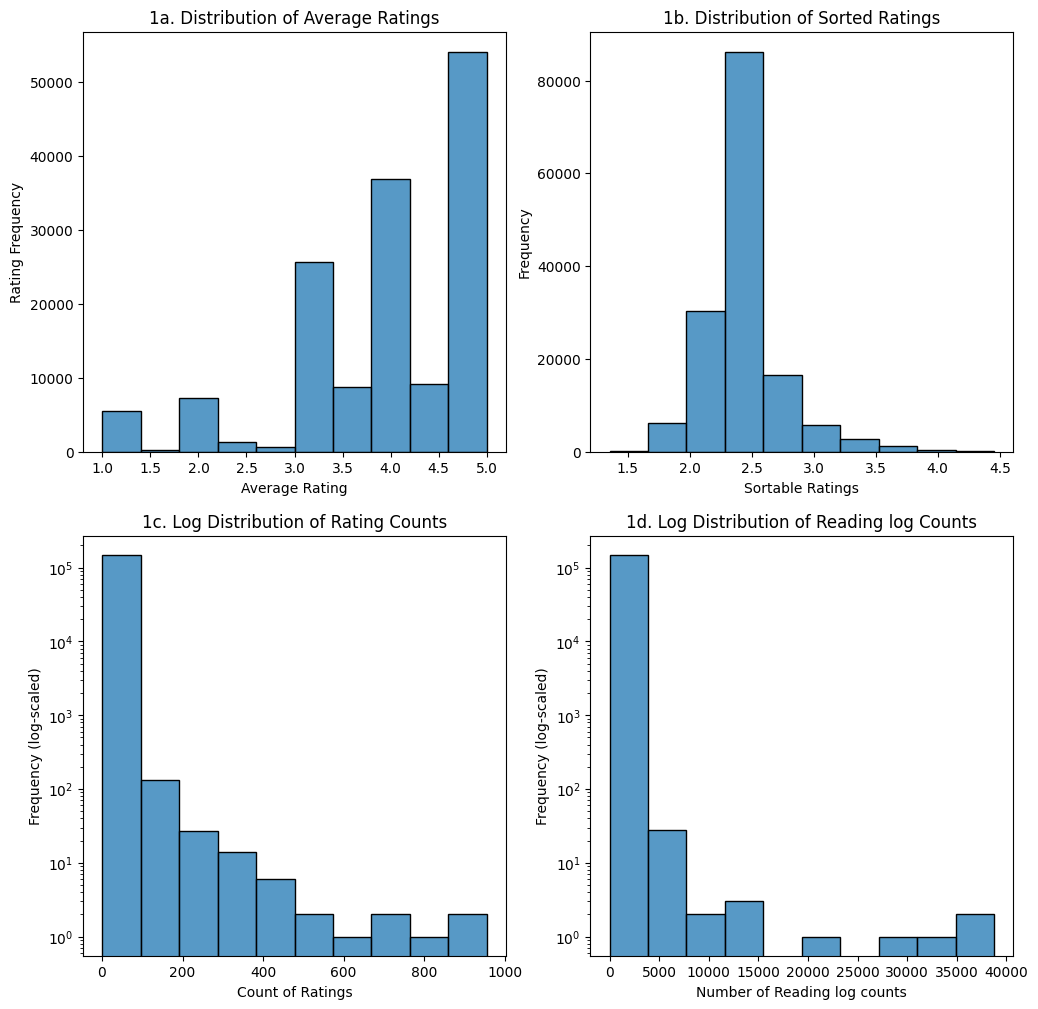

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Histogram for ratings_average
sns.histplot(data_df['ratings_average'], bins=10, ax=axes[0,0])
axes[0,0].set_title('1a. Distribution of Average Ratings')
axes[0,0].set_xlabel('Average Rating')
axes[0,0].set_ylabel('Rating Frequency')

# Plot 2: Histogram for ratings_sortable
sns.histplot(data_df['ratings_sortable'], bins=10, ax=axes[0,1])
axes[0,1].set_title('1b. Distribution of Sorted Ratings')
axes[0,1].set_xlabel('Sortable Ratings')
axes[0,1].set_ylabel('Frequency')

# Plot 3: Histogram for rating_count
sns.histplot(data_df['ratings_count'], bins=10, ax=axes[1,0])
axes[1,0].set_title('1c. Log Distribution of Rating Counts')
axes[1,0].set_xlabel('Count of Ratings')
axes[1,0].set_yscale('log')  # Apply log scale to x-axis labels
axes[1,0].set_ylabel('Frequency (log-scaled)')

# Plot 4: Histogram for readinglog_count
sns.histplot(data_df['readinglog_count'], bins=10, ax=axes[1,1])
axes[1,1].set_title('1d. Log Distribution of Reading log Counts')
axes[1,1].set_xlabel('Number of Reading log counts')
axes[1,1].set_yscale('log')  # Apply log scale to x-axis labels
axes[1,1].set_ylabel('Frequency (log-scaled)')

print("See below charts for commentary")

**Figure 1 Commentary**

**Figure 1a.** Shows that when average rating alone is considered, we see a positive skew toward 5/5. 
This could mean that "good books" engage readers to provide a rating more often - however it might also hint that
many of these high average ratings are overrepresented due to a low rating count. 
- It is worth noting that rating systems often show polarizing results because individuals are more likely to engage and provide feedback if their experience was "very bad"(1) or "Very good"(5) rather than if they had a "Moderate" or unremarkable experience (2-3). 

When compared with **figure 1b.** which examines Sorted Ratings (an internal measure from Open Library that appears 
to weigh the average rating according to its rating count) - we see a more 'normal' distribution around the center
rating of 2.5.

**Figures 1c and 1d** show the exponential rate at which the number of books decreases while their ratings count and 
reading log count increase. This indicates that, while most books on Open Library aren't receiving much engagement from
users (in the form of ratings and readinglog counts) - there is a small group of books that receive an outsized
amount of engagement (exponentially more). OpenLibrary can learn about its user preferences by taking a
closer look at this subgroup and asking questions like 'why these books generate so much engagement' and how focusing
limited resources on books like these can generate an outsized impact for its users.

The Pareto chart below (Figure 2) further illustrates the outsized impact of these 'super books' by ordering and binning them by Readinglog Count and then observing their cumulative Readinglog Counts as well as their Cumulative Percentage of Total Counts.

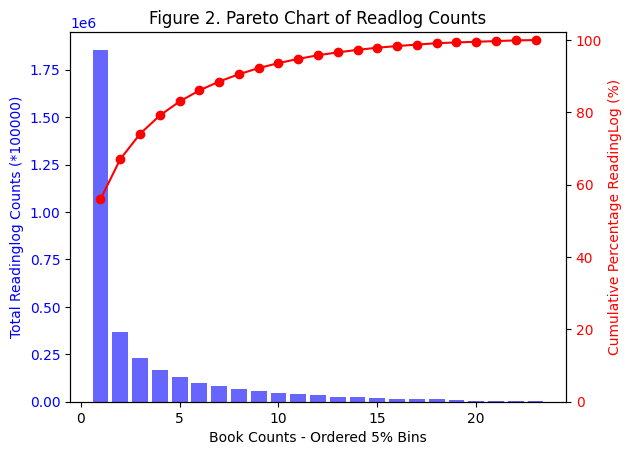

5% books account for nearly 50% of all readinglog count user engagements.


In [22]:
# Define the bin size as 5%
bin_size = len(data_df)/20

# Create bins and group by these bins
data_df['bin'] = (data_df.index // bin_size) + 1
bin_totals = data_df.groupby('bin')['readinglog_count'].sum().reset_index()

# Calculate cumulative sum and cumulative percentage
bin_totals['cumulative_sum'] = bin_totals['readinglog_count'].cumsum()
bin_totals['cumulative_percentage'] = bin_totals['cumulative_sum'] / bin_totals['readinglog_count'].sum() * 100

fig, ax1 = plt.subplots()

# Plot total read counts on the primary y-axis
ax1.bar(bin_totals['bin'], bin_totals['readinglog_count'], color='b', alpha=0.6)
ax1.set_xlabel('Book Counts - Ordered 5% Bins')
ax1.set_ylabel('Total Readinglog Counts (*100000)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot cumulative percentage on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(bin_totals['bin'], bin_totals['cumulative_percentage'], color='r', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage ReadingLog (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Set the y-axis lower limit to 0
ax2.set_ylim(bottom=0)


plt.title('Figure 2. Pareto Chart of Readlog Counts')
plt.show()

print("5% books account for nearly 50% of all readinglog count user engagements.")

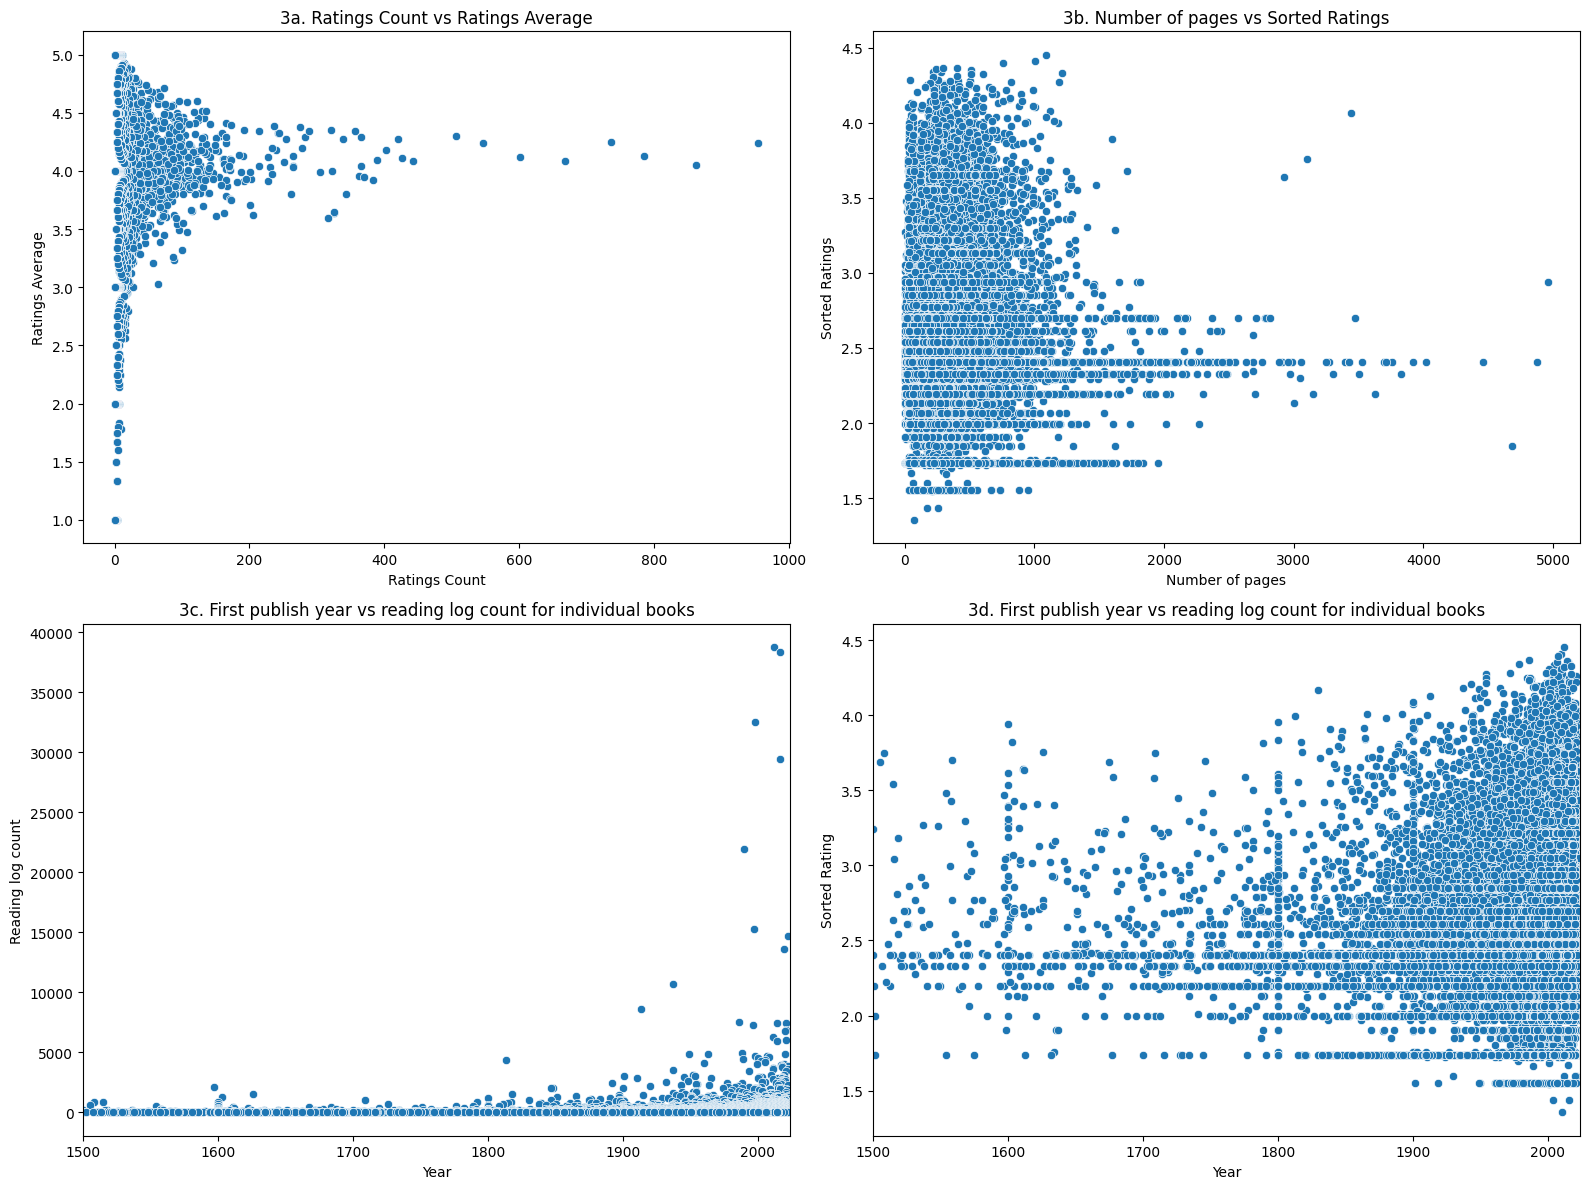

In [23]:
# Figure with 2x2 subplots examining the relationship between numeric measures
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 3a: Scatter plot of ratings_count vs. ratings_average
sns.scatterplot(x='ratings_count', y='ratings_average', data=data_df, ax=axes[0, 0])
axes[0, 0].set_title('3a. Ratings Count vs Ratings Average')
axes[0, 0].set_xlabel('Ratings Count')
axes[0, 0].set_ylabel('Ratings Average')

# Plot 3b: Scatter plot of median pages vs. ratings_sortable
sns.scatterplot(x='number_of_pages_median', y='ratings_sortable', data=data_df, ax=axes[0, 1])
axes[0, 1].set_title('3b. Number of pages vs Sorted Ratings')
axes[0, 1].set_xlabel('Number of pages')
axes[0, 1].set_ylabel('Sorted Ratings')

# Plot 3c: Scatter plot of median pages vs. readinglog_count
sns.scatterplot(x='first_publish_year', y='readinglog_count', data=data_df, ax=axes[1, 0])
axes[1, 0].set_title('3c. First publish year vs reading log count for individual books')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Reading log count')
# Set the x-axis lower limit to 1500
axes[1, 0].set_xlim(left=1500, right=2024)

# Plot 3d: Scatter plot of median pages vs. readinglog_count
sns.scatterplot(x='first_publish_year', y='ratings_sortable', data=data_df, ax=axes[1, 1])
axes[1, 1].set_title('3d. First publish year vs reading log count for individual books')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Sorted Rating')
# Set the x-axis lower limit to 1500
axes[1, 1].set_xlim(left=1500, right=2024)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

**Figure 3a.** Shows a marked decrease in Average Rating variation as the Rating count increases - suggesting that extreme rating averages (1 or 5) are the result of fewer (approaching 1) total ratings. Since the average rating for books that receive high rating counts seems to average between 4-4.5 we could ask further if readers who enjoy a book are more likely to leave a rating,  while also asking questions about the nature of book recommendations - are people more likely to read (and finish) good books in the first place? 
- If that is the case, could Open Library consider providing a book recommendation feature to  see if it increases user engagement, while using the Average Rating and conversion of books in  users' want_to_read to read lists as a measure of their recommender's performance?


**Figure 3b** shows a book's sorted rating plotted over its number of pages. While number of pages feels like a 'vanity metric' - and our graph appears to show no simple proportional relationship between the two up to somewhere between 1000-2000 pages, it looks like there might be an inflection point here after which there are much fewer high ratings. Perhaps this has to do with the nature of books that have >2000 pages, since they are likely no longer novels and may be textbooks or encyclopedias. 

**Figure 3c** shows us that the most popular handful of books according to reading log count were first published after 2000 (limited meaning since Open Library was only established in 2006)

**Figure 3d** shows us that there is a greater number of ratings for more recent novels (greater number of total reads by users) with greater variation but the overall average has not shifted in a meaningful way. 

#### Insights and Impressions from some initial exploratory analysis of Open Library's user engagement

Open Library is in a unique position as an organization that must balance its goal of 'one web page for every book ever published' with its goal of providing a user-friendly and engaging platform and tool for its users. 

With these competing priorities, initial data exploration suggests that Open Library has opportunities to:
- Reinforce its collection quality by improving the completeness and accuracy of its work entries
- Leverage more targeted measures of popularity and engagement for further analysis - for example page traffic, borrow counts 
- Explore its most popular works in more depth to identify what drives engagement for its users and how it can continue expanding and improving its service offerings to continue increasing engagement and attracting new users.
